# Can we detect patterns among specific consumers to identify potential fraud?

## Goals

By the end of this case, you will be familiar with $k$-means as a clustering algorithm. Specifically, you will learn the algorithm behind $k$-means to better intuit when it works well and when it doesn't.

During the case study, you will perform EDA on your data set and observe a natural clustering in the data. You will then be introduced to $k$-means as a way to automate this process. You will then go on to implement it and fine-tune the algorithm to validate your findings. Being able to dissect algorithms and tune your data to the algorithm is an important ability for any data scientist.

## Introduction

**Business Context.** You are working for the fraud team at a large insurance company which deals with issuing insurance policies for various types of claims to both individuals and businesses. Policies which are issued are kept track of and any filed claims are examined and evaluated to determine legitimacy and final approval for pay out by the insurance company. However, many individuals attempt to take advantage, filing claims under false pretenses to obtain extra income. It is the role of the fraud team to determine which filed claims should be approved and which should be denied.

**Business Problem.** Your task is to answer the following question: **Are there particular patterns in the groups of filed claims which may be indicative of fraud?**

**Analytical Context.** The accounting team has provided you with data on all recent claims made by 1000 individuals. Unlike previous cases, the data here will be unlabeled; i.e. there is no variable that tells us which of these claims are fraudulent or not. As a result, the classification models we have been using up until now cannot be used. We must instead use **clustering models** to tackle this **unsupervised learning** problem.

The case is structured as follows, we will:
1. perform exploratory data analysis to visually investigate the structure of the data
2. use these observations to guide our clustering methodology and fit the appropriate models
3. discuss the advantages and limitations of typical clustering methods; and finally
4. segment and generate conclusions on particular clusters

## Data exploration

In [1]:
# Importing all the required packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn

from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

%matplotlib inline

Let's start by importing the available data and looking at the first few rows:

In [2]:
# Importing the data, need the xlrd package

df_data = pd.read_excel('insurance_data_1000.xlsx')
df_data.head(5)

,case_id,income,age,sex,approval,fraud,claims
0,59982,35750.95,42,M,Approved,Under Review,9518.95
1,87249,24078.27,19,M,Denied,No,19354.23
2,50406,39241.52,37,M,Denied,Fraud,13056.04
3,59391,33248.31,26,M,Approved,No,19238.37
4,96622,38649.96,54,M,Approved,No,14427.42


In [3]:
# Interested in only a specific set of variables 

df = df_data[['case_id', 'income', 'age', 'claims']]
df.head(5)

,case_id,income,age,claims
0,59982,35750.95,42,9518.95
1,87249,24078.27,19,19354.23
2,50406,39241.52,37,13056.04
3,59391,33248.31,26,19238.37
4,96622,38649.96,54,14427.42


Next, let's take a look at the set of claims under review and how they are distributed:

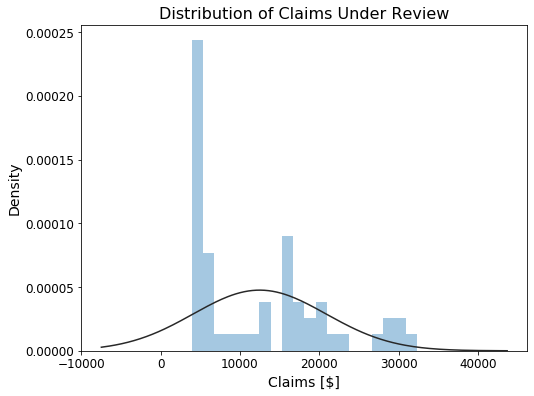

In [4]:
# These are cases labelled as under review 

plt.figure(figsize=(8,6))

df_frauds = df_data[df_data['fraud'] == 'Under Review']
x = df_frauds['claims']

sns.distplot(x, bins=20, kde=False, fit=norm)

plt.title('Distribution of Claims Under Review', fontsize=16)

plt.xlabel('Claims [$]', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)

plt.show()

This is a really strange distribution. It seems like there are three sets of peaks for the claim amounts. Let's try to look at some 2D scatterplots of `claims` vs. `income` and `income` vs. `age` for the sample population, in order to glean more insight into what is going on:

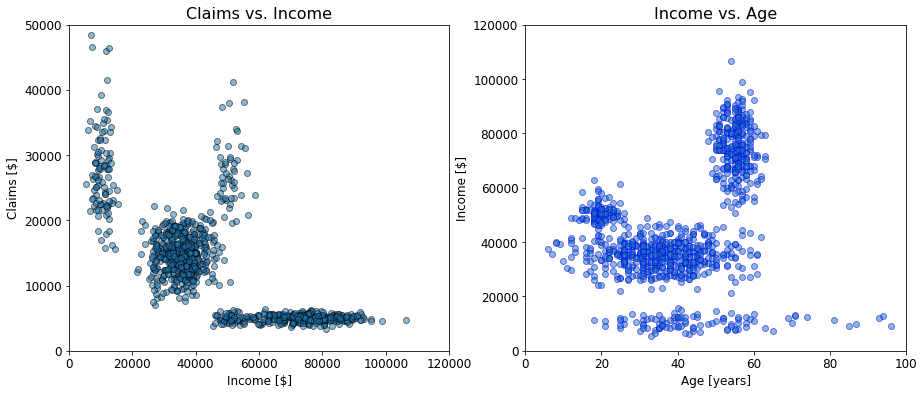

In [5]:
# Claims vs. Income
plt.figure(figsize=(15,6))

plt.subplot(121)

plt.scatter(df['income'], df['claims'], edgecolor='k', alpha=0.5)

plt.ylim(0, 50000)
plt.yticks(fontsize=12)
plt.ylabel('Claims [$]', fontsize=12)

plt.xticks(fontsize=12)
plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)

plt.title('Claims vs. Income', fontsize=16)

# Income vs Age
plt.subplot(122)

plt.scatter(df['age'], df['income'], edgecolor='b', alpha=0.5)

plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.xticks(fontsize=12)

plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.yticks(fontsize=12)

plt.title('Income vs. Age', fontsize=16)

plt.show()

We can also stratify our data by gender before performing the above visualizations:

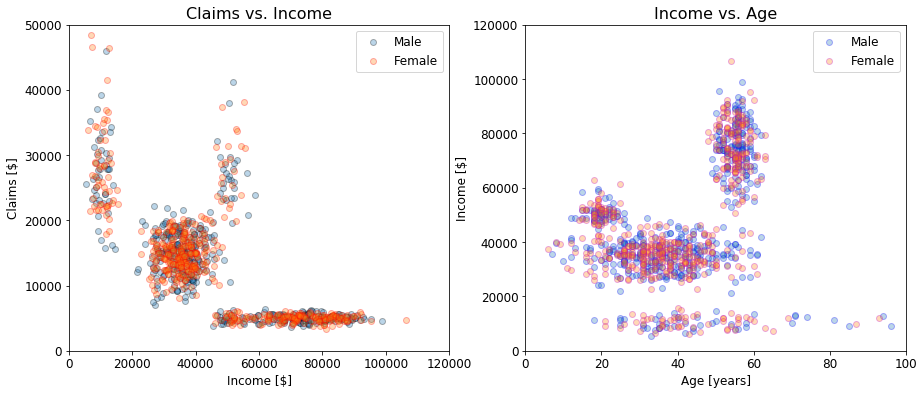

In [6]:
df_gender = df_data[['case_id', 'income', 'age', 'claims', 'sex']]
df_male = df_gender[df_gender['sex'] == 'M']
df_female = df_gender[df_gender['sex'] == 'F']

plt.figure(figsize=(15,6))

# Claims vs. Income - gendered
plt.subplot(121)

plt.scatter(df_male['income'], df_male['claims'], edgecolor='k', alpha=0.3, label='Male')
plt.scatter(df_female['income'], df_female['claims'], edgecolor='r', alpha=0.3, label='Female')

plt.legend(loc='best', fontsize=12)

plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)
plt.xticks(fontsize=12)

plt.ylim(0, 50000)
plt.ylabel('Claims [$]', fontsize=12)
plt.yticks(fontsize=12)

plt.title('Claims vs. Income', fontsize=16)

# Income vs. Age - gendered
plt.subplot(122)

plt.scatter(df_male['age'],df_male['income'], edgecolor='b', alpha=0.3, label='Male')
plt.scatter(df_female['age'],df_female['income'], edgecolor='m', alpha=0.3, label='Female')

plt.legend(loc='best', fontsize=12)

plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.xticks(fontsize=12)

plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.yticks(fontsize=12)

plt.title('Income vs. Age', fontsize=16)

plt.show()

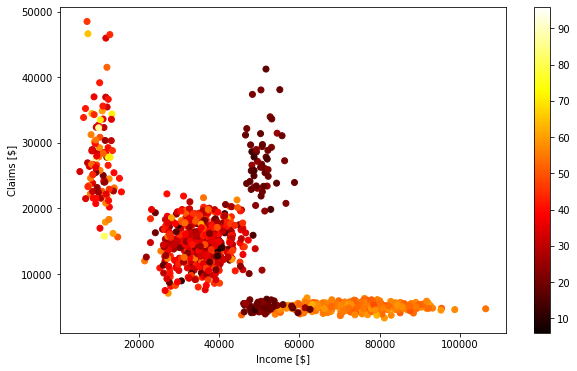

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(df.income, df.claims, c=df.age,cmap='hot')
plt.ylabel('Claims [$]')
plt.xlabel('Income [$]')
plt.colorbar()

### Exercise 1:

What patterns do you notice in the plots above? Why do you think these might be happening?

**Answer.**

There do not seem to be large differences in the distributions based on gender; however, the gender-agnostic plots do display some clear clusters. For example, there is a giant cluster of claims around the $30,000 - $40,000 income range on the claims vs. income chart, which could be due to the fact that the median income is approximately $30,000 - $40,000. There is also a strip of claims from $50,000 - $100,000 on the claims vs. income chart, which are worth $5,000 or so. It is unclear exactly what these claims are, but they could be everyday things that more affluent individuals may deal with (e.g. auto accident claims). 

There is also a strip of claims for at least $20,000 among people who make only $10,000, which is unusual and may well consist of fraudulent claims.

On the income vs. age chart, there is a strip of people earning $10,000 across all ages (minimum wage), a large cluster of people earning between $30,000 - $40,000 across all ages (median wage), and a lot of higher-income individuals ($60,000 - $100,0000) right before age 60. Age 59 1/2 is when individuals in the US can start taking out savings from their retirement accounts, so this may have something to do with this pattern.

--------

### Question:

How would you go about creating an algorithm that finds the clusters we have determined through "eyeballing" in the figures above? Discuss with a partner.

## $k$-means clustering 

In our visualizations above, there seem to exist distinct populations of individuals based on the relationships between claims and income, and income and age. However, we have only managed to investigate two relationships this way, and in larger datasets with many features, doing so manually across all variables can be very time-consuming. Luckily, **clustering models** allow us to summarize and detect potentially interesting relationships rather quickly.

There are many variations of clustering, but the most common, and the one we will be looking at, is called **$k$-means clustering**. This algorithm separates the given dataset into $k$ groups that minimizes the sum of the squares of distances between every pair of points in the group. The data scientist needs to pre-select the value of $k$, which may require prior analysis to determine.

The method has 3 broad steps, which can be summarized as follows:

1. Initialization. To start, one must select $k$ points (not necessarily any of the data points, just points in the same dimensional space) as the "initial" centroids.
2. Assignment. Each data point is assigned to the cluster corresponding to the centroid that is closest to itself (usually based on standard Euclidean distance).
3. Update. Once all data points have been assigned to their respective clusters, a new centroid is calculated for each cluster by taking the mean of all the points in that cluster.

Steps 2 and 3 are then repeated until the clusters no longer change.

### Exercise 2:

$k$-means clustering relies on minimizing the Euclidean distance between data points. What sorts of problems might this pose in terms of the results we get? How might we fix this?

**Answer.**

There is a problem of scaling that could occur. If some variables naturally have very small values while others have very large values, then the features are de-facto not weighted evenly in the Euclidean distance calculation. To fix this, we would need to scale each variable appropriately by a measure of its size; for example, we could divide everything by the median value of said variable.


--------

There are many ways of scaling, or **normalizing**, variables, one of which we have hinted at above. The best normalization choice depends on the particular details of the dataset at hand.

Similarly, the Euclidean distance is the most commonly used metric to compute the clusters, as it is quite easy to compute and performs well on most datasets, but it is not the only one. Data scientists sometimes use variations on the distance metric depending on the dataset they are investigating. Therefore, it is a parameter which should be considered and explored during the EDA stage to determine what is best to proceed with.

### Exercise 3:

Write a function which will normalize `age`, `income`, and `claims` according to the minimum and maximum values of each variable. For example, if we are talking about `age`, then a normalized value for an age $A$ would be computed as $\displaystyle\frac {X - min(age)} {max(age) - min(age)}$. (This is known as the min-max scaling method.)

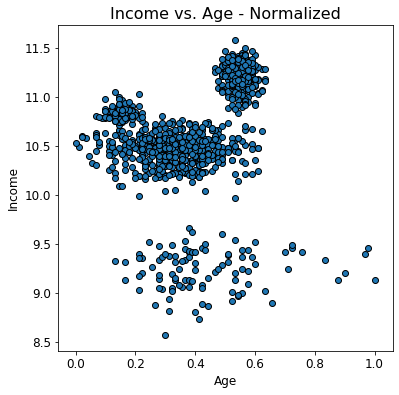

In [8]:
# Function Normalize
# Input = df, DataFrame we are interested in normalizing
# This is the Min/Max scaling method 
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)
    return result
# Create new DataFrame containing normalized data 
df_norm = normalize(df[['age', 'income', 'claims']])
# Claims vs. Income - Normalized
plt.figure(figsize=(6, 6))
plt.scatter(df_norm['age'], np.log(df['income']), edgecolor='k')
#plt.xlim(-0.05, 1.05)
plt.xlabel('Age', fontsize=12)
plt.xticks(fontsize=12)
#plt.ylim(-0.05, 1.05)
plt.ylabel('Income', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Income vs. Age - Normalized', fontsize=16)
plt.show()

**Answer.**

The methods shown above will transform the data in such a way that the magnitude of all the features is roughly similar. However, there may be a different scaling method which allows 𝑘
k-means clustering to perform better. The best choice of scaling method depends on the specific data provided

--------

### Exercise 4:

Imagine a situation where in addition to our original dataset, there were a few high-income earners who also filed high-valued claims. What might go wrong with our scaling method above? How might you deal with this?

**Answer.**

These data points would present themselves in the top right of our claims vs. income plot, and would generally be one-off (i.e. not frequent) occurences. However, they would significantly affect our min-max scaling method (much like how outliers significantly affect regression models) and thus our clustering process.
One solution would be to omit these data points as they do not occur too frequently (one plausible explanation is that the data may have been accidentally entered with an additional 0, hence inflating their values). However, deleting data points from consideration is a big move and a nuclear option that we generally don't want to pull out if we can avoid it. In general, we would like to use more robust scaling procedures which can naturally deal with such outliers. One generally accepted way of scaling is dividing by the standard deviation.

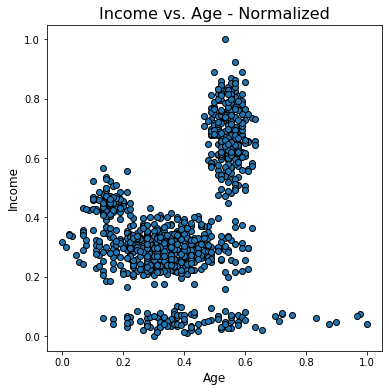

In [9]:
# Claims vs. Age - Normalized
plt.figure(figsize=(6, 6))
plt.scatter(df_norm['age'], df_norm['income'], edgecolor='k')
plt.xlim(-0.05, 1.05)
plt.xlabel('Age', fontsize=12)
plt.ylim(-0.05, 1.05)
plt.ylabel('Income', fontsize=12)
plt.title('Income vs. Age - Normalized', fontsize=16)
plt.show()

--------

## Initialization of the clusters

Based on the normalized data, we can make an educated assumption that we have 4 groups:

1. high incomes and low claims
2. moderate incomes and moderate claims
3. moderate incomes and high claims
4. low incomes and high claims

Let's investigate further to determine if this is the best way of clustering the data. We must start by initializing the first values of the centroids: 

Initial Centroids (income, claims) are: 
 {1: array([0.8488177 , 0.17889592]), 2: array([0.05436321, 0.36153845]), 3: array([0.27540093, 0.53000022]), 4: array([0.30591892, 0.30447436])}


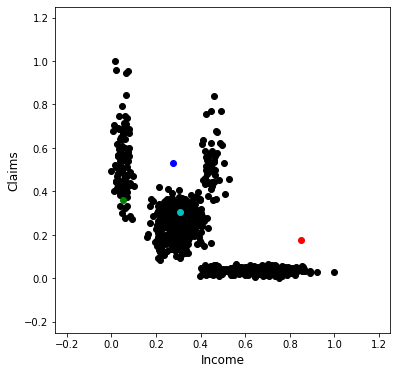

In [10]:
# Now we will begin our k-means method:

# Assign how many clusters (k-number) you would like to have
# This is only one implementation (crude) method of initializing the cluster centers
k = 4

#Select random centers:
np.random.seed(15)
centroids = {i+1: np.random.rand(1,2)[0] for i in range(k)}

print("Initial Centroids (income, claims) are: \n", centroids)

plt.figure(figsize=(6, 6))

plt.scatter(df_norm['income'], df_norm['claims'], color='k')

color_map = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=color_map[i])

plt.xlim(-0.25,1.25)
plt.xlabel('Income', fontsize=12)

plt.ylim(-0.25,1.25)
plt.ylabel('Claims', fontsize=12)

plt.show()

Then, we classify each point using the closest centroid. This can be done as follows:

In [11]:
#This function outputs the closest centroid:
def nearest_neigh(row,centroids):
    dist=np.inf
    nearest=0
    point=np.array([row['income'],row['claims']])
    for idx,cent in centroids.items():
        dist0=np.linalg.norm(point-np.array(cent))
        if dist>dist0:
            dist=dist0
            nearest=idx
    return nearest

#We store the resulting centroid in the dataframe
df_norm['classification']=df_norm.apply(lambda x: nearest_neigh(x,centroids),axis=1)

#Next, we compute the new centroids
centroids_new=centroids.copy()
for idx in centroids_new.keys():
    centroids_new[idx]=np.array(df_norm[df_norm['classification']==idx][['income','claims']].mean())
    if np.isnan(centroids_new[1][0]) :
        centroids_new[idx]=centroids[idx]

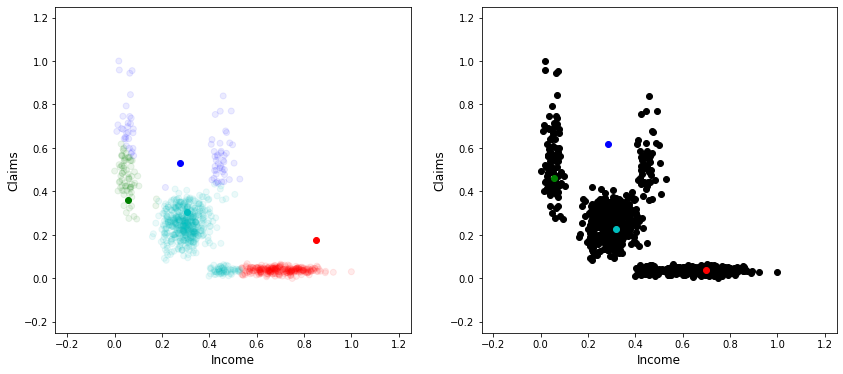

In [12]:
#Let us plot our findings:

fig,ax=plt.subplots(1,2,figsize=(14, 6))
color_map = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}

#First plot shows the current classification with old centroids
ax[0].scatter(df_norm['income'], df_norm['claims'], c=df_norm['classification'].apply(lambda x: color_map[x]),alpha=0.08)
for i in centroids.keys():
    ax[0].scatter(*centroids[i], color=color_map[i])

ax[0].set_xlim(-0.25,1.25)
ax[0].set_xlabel('Income', fontsize=12)
ax[0].set_ylim(-0.25,1.25)
ax[0].set_ylabel('Claims', fontsize=12)

#Second plot shows the new centroids
ax[1].scatter(df_norm['income'], df_norm['claims'], color='k')
for i in centroids_new.keys():
    ax[1].scatter(*centroids_new[i], color=color_map[i])

ax[1].set_xlim(-0.25,1.25)
ax[1].set_xlabel('Income', fontsize=12)
ax[1].set_ylim(-0.25,1.25)
ax[1].set_ylabel('Claims', fontsize=12)

plt.show()


### Exercise 5:

Create similar plots that show the results of the next iteration of the algorithm.

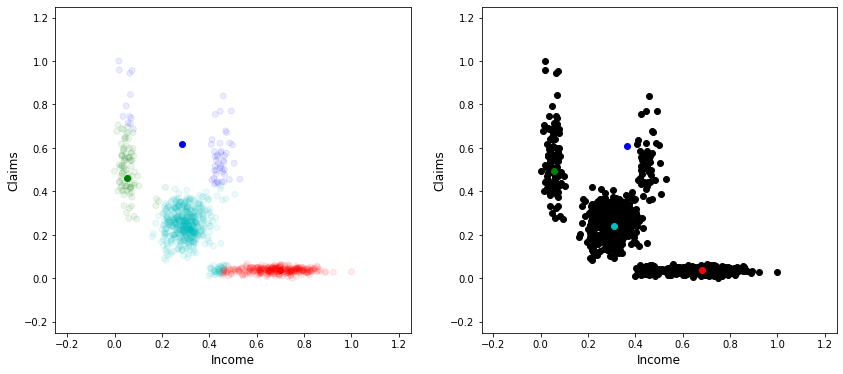

In [13]:
#We set the old centroids
centroids_old=centroids_new.copy()
#We store the resulting centroid in the dataframe
df_norm['classification']=df_norm.apply(lambda x: nearest_neigh(x,centroids_old),axis=1)
#Next, we compute the new centroids
for idx in centroids_new.keys():
    centroids_new[idx]=np.array(df_norm[df_norm['classification']==idx][['income','claims']].mean())
    if np.isnan(centroids_new[1][0]) :
        centroids_new[idx]=centroids_old[idx]
#Let us plot our findings:
fig,ax=plt.subplots(1,2,figsize=(14, 6))
color_map = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}
#First plot shows the current classification with old centroids
ax[0].scatter(df_norm['income'], df_norm['claims'], c=df_norm['classification'].apply(lambda x: color_map[x]),alpha=0.08)
for i in centroids.keys():
    ax[0].scatter(*centroids_old[i], color=color_map[i])
ax[0].set_xlim(-0.25,1.25)
ax[0].set_xlabel('Income', fontsize=12)
ax[0].set_ylim(-0.25,1.25)
ax[0].set_ylabel('Claims', fontsize=12)
#Second plot shows the new centroids
ax[1].scatter(df_norm['income'], df_norm['claims'], color='k')
for i in centroids_new.keys():
    ax[1].scatter(*centroids_new[i], color=color_map[i])
ax[1].set_xlim(-0.25,1.25)
ax[1].set_xlabel('Income', fontsize=12)
ax[1].set_ylim(-0.25,1.25)
ax[1].set_ylabel('Claims', fontsize=12)
plt.show()

**Answer.**

Here, we've implemented a crude initialization of the cluster means. In our example above, our initial clusters were well-positioned and we were able to find reasonably good results after just two iterations (at least if we only account for `income` and `claims`). However, the algorithm can be pretty sensitive to initialization (for instance, try to change the random seed to 2020 - the red centroid ends up being too far for the classifier to work as expected). Fortunately for us, the `KMeans` package from `sklearn` already has the initialization preset to a more sophisticated method: `k-means++`.
The main idea behind the initialization algorithm of `k-means++` is to set initial centroids as random points in our data set which are expected to be well-distanced from one another. More concretely:
1. Select a centroid $c_1$ at random from our data set. 
2. Calculate the squared distance from each other point in the dataset to $c_1$ and randomly choose the second centroid $c_2$ according to the observed distances (the higher the squared distance, the higher the chance to pick the point as a centroid).
3. We repeat the same procedure with subsequent centroids, but instead randomly choose those according to the squared distance to the closest of the centroids already selected.
This algorithm has been proved to be a [good approximation](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf) to the $k$-means optimal solution. Thus, it is a very good start for the main algorithm. We will work with this from here on out.

### Implementation of $k$-means++ using `sklearn`

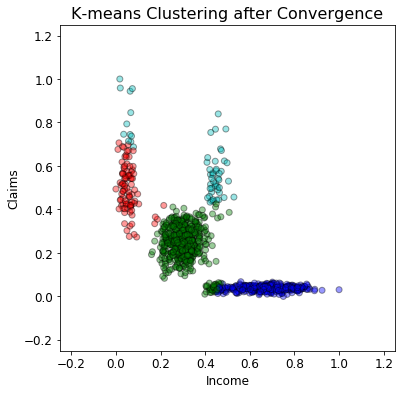

In [14]:
k = 4

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(df_norm)

# Iterative procedure to learn labels  
labels = kmeans.predict(df_norm)
centroids = kmeans.cluster_centers_

# Plot the data learned
plt.figure(figsize=(6, 6))

color_map = {1:'r', 2:'g', 3:'b' , 4:'c', 5:'y', 6:'w'}
colors = [color_map[x+1] for x in labels]

plt.scatter(df_norm['income'], df_norm['claims'], color=colors, alpha=0.4, edgecolor='k')

# for idx, centroid in enumerate(centroids):
#     plt.scatter(*centroid, marker='*', edgecolor='k')

plt.xlim(-0.25, 1.25)
plt.xlabel('Income', fontsize=12)
plt.xticks(fontsize=12)

plt.ylim(-0.25, 1.25)
plt.ylabel('Claims', fontsize=12)
plt.yticks(fontsize=12)

plt.title('K-means Clustering after Convergence', fontsize=16)

plt.show()

## Selecting the optimal value for $k$

Even though visual analysis suggests that $k = 4$ is the optimal value, it is good practice to verify this quantitatively as opposed to just eyeballing it. This is especially important when clustering data which cannot be easily visualized, a common occurrence with complex multidimensional data.

### Exercise 6:

How might you go about constructing a quantitative method for determining the optimal $k$? 

**Answer.**

Since the 𝑘-means algorithm minimizes the sum of squares within each cluster, this is the objective function that we ought to compare all possible values of 𝑘 to. We can construct a line graph showing how this sum of squares changes as 𝑘 changes, then select the value of 𝑘 with the lowest value.
However, this method doesn't quite work – imagine the case where you have an equal number of clusters as data points. Then the sum of squares is obviously zero, but one could hardly argue that such a clustering is a good idea! Therefore, it is prudent to add a penalty term (similar to how the AIC metric contains a penalty term) corresponding to the value of 𝑘. This will allow our graph to bottom out long before 𝑘 gets too large as the incremental benefit of adding just one more cluster diminishes as 𝑘 grows, while the incremental penalty increases.
The method described in Exercise 5 is a form of regularization; however, we are not ready just yet to get there. For now, we will be a little unscientific about this, instead leaving out the penalty term and looking for the value of 𝑘 on the line graph past which the change in sum of squares is effectively insignificant. This is called the elbow method.

--------

The method described in Exercise 5 is a form of **regularization**; however, we are not ready just yet to get there. For now, we will be a little unscientific about this, instead leaving out the penalty term and looking for the value of $k$ on the line graph past which the change in sum of squares is effectively insignificant. This is called the **elbow method**.

### Exercise 7:

Implement the elbow method scheme we described above. Does our initial guess of $k$ seem correct?

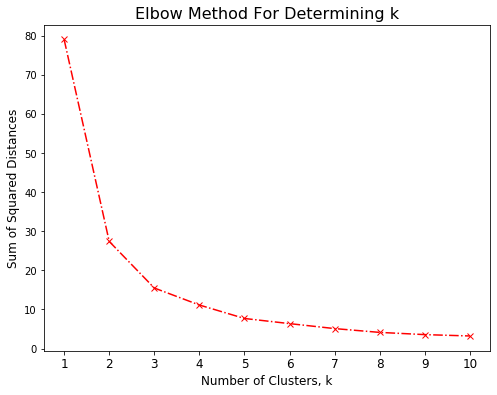

In [15]:
sum_sq_d = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_norm[['income', 'claims']])
    sum_sq_d.append(km.inertia_)
plt.figure(figsize=(8,6))
plt.plot(K, sum_sq_d, 'rx-.')
plt.xlabel('Number of Clusters, k', fontsize=12)
plt.xticks(range(1,11), fontsize=12)
plt.ylabel('Sum of Squared Distances', fontsize=12)
plt.xticks(fontsize=12)
plt.title('Elbow Method For Determining k', fontsize=16)
plt.show()

**Answer.**

It would seem from the graph that the value of adding more clusters really starts to diminish around $k = 3$. $k = 4$ is very close to that, so we can say that our initial guess was on point (it's quite common for our visual guess and the output of the method above to be slightly different). Recall, this method is working in mutliple dimensions so while the clustering may be obvious in one dimension, it may disappear in when combined with more variables.

--------

### Exercise 8:

Given the four clusters of claims we identified based on the income vs. claims chart, and taking into account the information on the income vs. age chart, make a suggestion about what the department should do with each cluster.

**Answer.**

We have four groups. The first is those with high incomes and low claims, which are most likely ordinary claims made by affluent families. It is very likely that these are not fraudulent and that the company should accept them. The second is moderate incomes with moderate claim values. These are quite plentiful and could be everyday items like auto claims. Most likely, we should accept these. The third is moderate incomes and high claims. This could be plausible if it is something that middle income individuals need but cannot always afford, like certain health claims. So we should probably investigate these further. The final category is low income but very high claims. These are clearly not affordable and with the exception of something like health claims, could well be attempts to garner free cash. We should most likely reject these.

--------

### Exercise 9:

Given what you have learned about the $k$-means algorithm, what are some potential drawbacks when it is applied to datasets?

**Answer.**

The 𝑘-means algorithm gives more weight to larger clusters as it is trying to minimize intra-cluster variation, so in cases where the clusters are naturally not the same size this could result in skewed results.
It does not necessarily converge in a uniform or quick way, so choosing the initial points is extremely important. This degree of dependency is not necessarily ideal.
Outliers may heavily influence the data and cluster means, unless an alternative metric is used.

--------

## Conclusions

In this case, we successfully split the dataset into 4 separate clusters, and validated our intuition based on $k$-means clustering. We learned that there are many built-in assumptions in $k$-means clustering (namely, the choice of distance metric, normalization, and $k$) and that this cannot easily be automated, as these choices depend on the particular dataset at hand. Once the individual groups have been identified, the insurance company can now determine which claims to give further investigation into or deem immediately as fraudulent based on some additional criteria.

## Takeaways

In this case, we introduced the concepts of **unsurpervised learning** and **clustering** techniques. Particularly, we discussed the **$k$-means** algorithm and its internal workings. We did this by:

1. Visualizing a data set to generate possible clusters in our data
2. Introducing the concept of $k$-means and how the algorithm works
3. Altering the data to conform to the pitfalls of the algorithm
4. Validating our initial hypothesis of the clusters in the data by implementing the algorithm

Clustering is a powerful unsupervised learning tool for investigating non-labeled data, particularly for determining patterns which were not previously known or understood. In the case of large datasets, highly complex relationships may be identified among groups of individual data points that one could not possibly do via the human eye.

While this is a nice technique for low dimensional data, $k$-means is susceptible to poor performance in higher dimensions like many machine learning algorithms. In higher dimensions, more advanced techniques, such as **t-SNE**, are first done to reduce the number of dimensions before clustering. Finally, $k$-means is only one of many clustering algorithms. Modern developments include the **DBSCAN** and **OPTICS** algorithms.

## Appendix: manual $k$-means implementation & monitoring

Here we show how the actual $k$-means algorithm works, from initialization of the clusters, to the updating steps, to the final result:

Initial Centroids (age, income) are: {1: [-1.0, -0.5], 2: [0.25, 0.25], 3: [-0.5, -1.0], 4: [0.5, 0.25]}
        age    income    claims  classification  distance_from_1  \
0  0.400000  0.301264  0.137252               4             1.45   
1  0.144444  0.185900  0.355004               2             1.46   
2  0.344444  0.335762  0.215563               4             1.52   
3  0.222222  0.276530  0.352439               4             1.53   
4  0.533333  0.329915  0.245925               4             1.52   

   distance_from_2  distance_from_3  distance_from_4  closest color  
0             0.12             1.39             0.23        2     g  
1             0.12             1.52             0.33        2     g  
2             0.09             1.48             0.17        2     g  
3             0.11             1.56             0.25        2     g  
4             0.08             1.50             0.17        2     g  


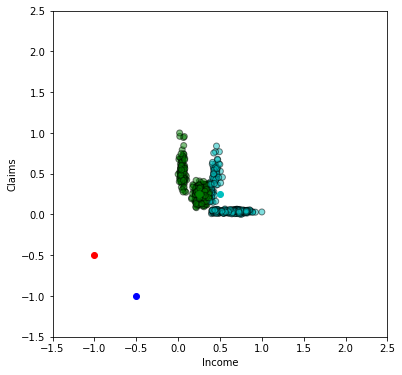

In [16]:
# Now we will begin our k-means method:

# assign how many clusters (k-number) you would like to have
k = 4

# Initialization of cluster means 
centroids = {i+1: [np.random.choice([-1,-0.5,0.25,0.5]), np.random.choice([-1,-0.5,0.25,0.5])]
    for i in range(k)
}

print(f"Initial Centroids (age, income) are: {centroids}")

color_map = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}

def assignment(df, centroids):
    tmp = df.copy()
    for i in centroids.keys():
        tmp[f"distance_from_{i}"] = (np.sqrt(
            (df['income'] - centroids[i][0])**2 + (tmp['claims'] - centroids[i][1]) ** 2)
        ).round(2)
        
    centroid_distance_cols = [f"distance_from_{i}" for i in centroids.keys()]
    
    tmp['closest'] = tmp.loc[:, centroid_distance_cols].idxmin(axis=1)
    tmp['closest'] = tmp['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    tmp['color'] = tmp['closest'].map(lambda x: color_map[x])
    
    return tmp

df_centroids = assignment(df_norm, centroids)
print(df_centroids.head())

plt.figure(figsize=(6, 6))
plt.scatter(df_centroids['income'], df_centroids['claims'], color=df_centroids['color'], alpha=0.5, edgecolor='k')

for i in centroids.keys():
    plt.scatter(*centroids[i], color=color_map[i])
    
plt.xlim(-1.5, 2.5)
plt.xlabel('Income')

plt.ylim(-1.5, 2.5)
plt.ylabel('Claims')

plt.show()

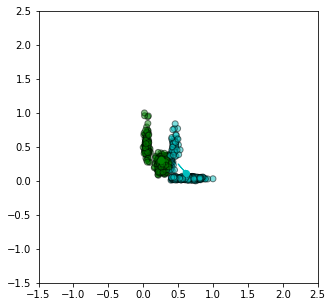

In [17]:
# Update Step: In this step, we are taking updating the mean, by now calculating it based on
# all the data points which were assigned to that k-th cluster.

# Copy previous values and make a new entry called old_centroids. 
import copy

old_centroids = copy.deepcopy(centroids)

# Function to update the k-th clusters. 
def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df_centroids[df_centroids['closest'] == i]['income'])
        centroids[i][1] = np.mean(df_centroids[df_centroids['closest'] == i]['claims'])
    return k

centroids = update(centroids)
    
plt.figure(figsize=(5, 5))
ax = plt.axes()

plt.scatter(df_centroids['income'], df_centroids['claims'], color=df_centroids['color'], alpha=0.5, edgecolor='k')

for i in centroids.keys():
    plt.scatter(*centroids[i], color=color_map[i])
    
plt.xlim(-1.5, 2.5)
plt.ylim(-1.5, 2.5)

for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    
    ax.arrow(old_x, old_y, dx, dy, head_width=0.05, head_length=0.03, fc=color_map[i], ec=color_map[i])
    
plt.show()

Note that centroids may disappear because they are initialized empty! This is an important thing for you to remember. If you have a rough idea of where the centroids are, initialize the algorithm. There is no substitute for prior knowledge. Fortunately for us, `sklearn` handles degenerate cases like this and holds $k$ constant.

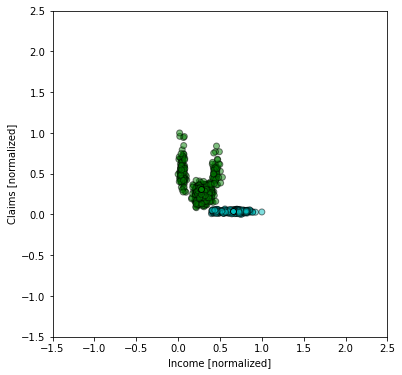

In [18]:
# Iterative procedure: Reassign new weights 
df_centroids = assignment(df_centroids, centroids)

# Continue doing this until no new assignments have been made 
while True:
    closest_centroids = df_centroids['closest'].copy(deep=True)
    centroids = update(centroids)
    df_centroids = assignment(df_centroids, centroids)
    
    if closest_centroids.equals(df_centroids['closest']):
        break

plt.figure(figsize=(6, 6))
plt.scatter(df_centroids['income'], df_centroids['claims'], color=df_centroids['color'], alpha=0.5, edgecolor='k')

for i in centroids.keys():
    plt.scatter(*centroids[i], color=color_map[i], edgecolor='k')
    
plt.xlim(-1.5, 2.5)
plt.xlabel('Income [normalized]')

plt.ylim(-1.5, 2.5)
plt.ylabel('Claims [normalized]')

plt.show()